In [1]:
from __future__ import division, print_function
import numpy as np
from matplotlib import pyplot as plt

import dask
from dask.dot import dot_graph

In [2]:
# Load Data
from sklearn.datasets import load_digits

digits = load_digits()
X = np.asarray(digits.data, 'float32')
y = digits.target
print(X.shape, y.shape)

(1797, 64) (1797,)


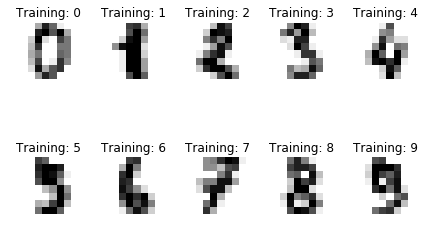

In [3]:
# Look at Data
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)
plt.tight_layout()
plt.show()

In [4]:
# Set up Distributed
from distributed import Executor
exc = Executor('10.195.128.140:8786', set_as_default=True)
print(exc)


<Client: scheduler='tcp://10.195.128.140:8786' processes=8 cores=8>


In [5]:
# Parameter Grid
from sklearn.model_selection import ParameterGrid, KFold

reg_params = np.logspace(1, 3, 4)
kern_params = np.logspace(-5, -3, 4)
params = ParameterGrid({'C': reg_params, 'gamma': kern_params})
n_folds = 4

kf_test = KFold(n_folds)
score_params = []
test_scores = []

In [6]:
from dask import delayed
from sklearn.svm import SVC

@delayed
def train_test(params, train_idx, test_idx, X, y):
    svm = SVC(probability=True, **params)
    svm.fit(X[train_idx, :], y[train_idx])
    return svm.score(X[test_idx, :], y[test_idx])

In [7]:
for model_sel_idx, test_idx in kf_test.split(X):
    X_train = X[model_sel_idx]
    y_train = y[model_sel_idx]

    for param in params:
        kf = KFold(n_folds)
        scores = [train_test(param, train_idx, val_idx, X_train, y_train)
                  for train_idx, val_idx in kf.split(X_train)]
        score = delayed(sum)(scores) / n_folds
        score_params.append((score, param))

    best_param = delayed(max)(score_params,key= lambda item: item[0])[1]
    test_scores.append(train_test(best_param, model_sel_idx, test_idx, X, y))

test_score = delayed(sum)(test_scores) / n_folds


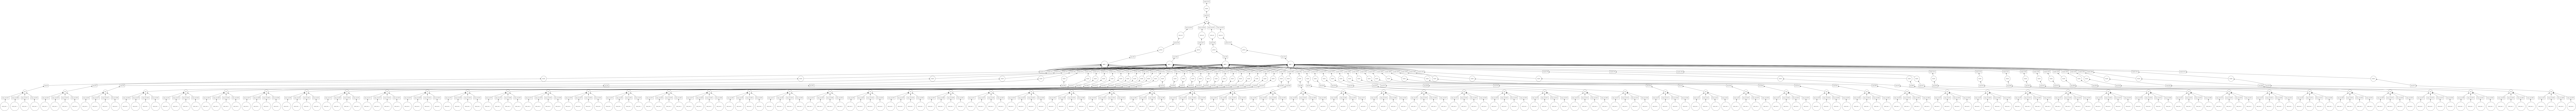

In [8]:
test_score.visualize(filename="dask_graph.png")

In [9]:
avg_score, last_best_param = dask.compute(test_score, best_param)
print('Avg Accuracy', avg_score)
print(last_best_param)

Avg Accuracy 0.976628309824
{'C': 10.0, 'gamma': 0.001}


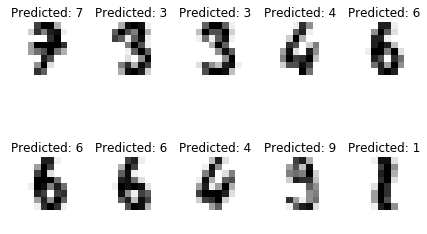

distributed.client - WARNING - Client report stream closed to scheduler


In [10]:
# Predict some
svm = SVC(**last_best_param)
svm.fit(X[model_sel_idx, :], y[model_sel_idx])
y_pred = svm.predict(X[test_idx, :])
for index, (image, label) in enumerate(list(zip(digits.images[test_idx], y_pred))[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Predicted: %i' % label)
plt.tight_layout()
plt.show()